In [1]:
import numpy as np

from matplotlib import pyplot as plt

In [2]:
rng = np.random.default_rng()

In [3]:
x = np.linspace(-1,1,50)
y1 = np.sqrt(1-x**2)
y2 = -y1

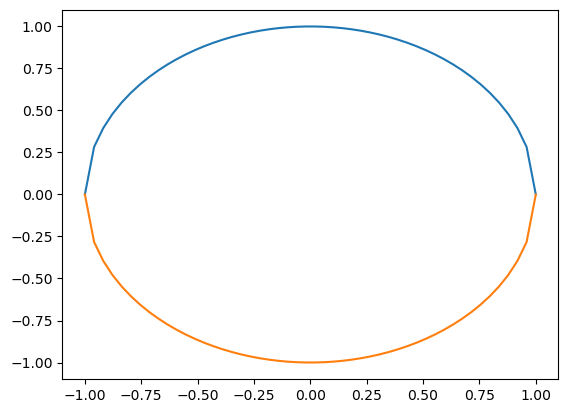

In [4]:
fig, ax = plt.subplots()

ax.plot(x,y1)
ax.plot(x,y2)

In [5]:
n = 1000
x_samples = rng.uniform(low = 0., high = 1., size = n)
y_samples = rng.uniform(low = 0., high = 1., size = n)

# 1. using numpy and matplotlib, generate and plot 1000 random data points in the unit square
# (hint: you need both x- and y-coordinates)


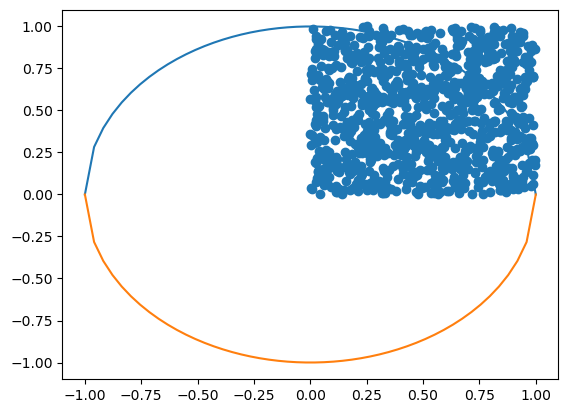

In [6]:
fig, ax = plt.subplots()

ax.plot(x,y1)
ax.plot(x,y2)
ax.scatter(x_samples, y_samples)

In [7]:

# 2. compute the radius of each point
def distance(x2, y2):
    return np.sqrt(np.power(x2,2) + np.power(y2,2))


In [8]:
distances = distance(x_samples, y_samples)

In [9]:

# 3. sort the points depending on whether they are inside (radius <= 1) or outside the unit circle
sort_inside = np.where(distances <= 1)
sort_outside = np.where(distances > 1)

In [10]:

# 4. plot the two classes (inside and outside) of points with different colors


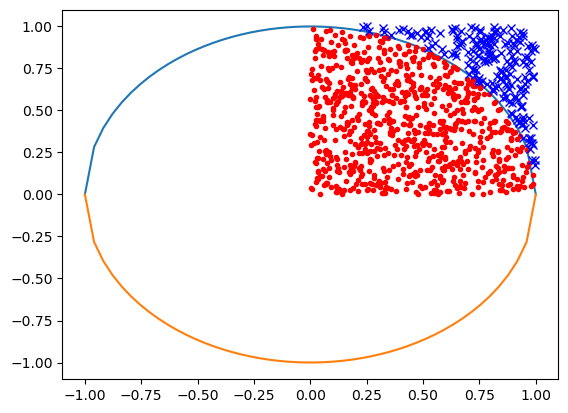

In [11]:
fig, ax = plt.subplots()

ax.plot(x,y1)
ax.plot(x,y2)
ax.plot(x_samples[sort_inside], y_samples[sort_inside], 'r.')
ax.plot(x_samples[sort_outside], y_samples[sort_outside], 'bx')

In [12]:

# 5. compute the ratio of the number of points inside the circle and outside the circle, multiply that ratio
# with 4 and see how close to pi you get


In [15]:
ratio = sort_inside[0].shape[0] / n
pi_estimate = 4*ratio
print(pi_estimate)

3.228


In [16]:
import pycuda.autoinit
import pycuda.driver as cuda
import numpy

from pycuda.compiler import SourceModule

mod = SourceModule("""
__global__ void cudaPI(float* dest) {
    // find global index of thread in x- and y-dimension
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;
    
    // linearized (1D) global index of thread
    int idx = i + j*(gridDim.x * blockDim.x);
    
    // compute distance between threads
    // (each thread representing one point placed on the 1st "unit circle quadrant", see image above)
    float dx = 1.0f / (float) (gridDim.x * blockDim.x);
    float dy = 1.0f / (float) (gridDim.y * blockDim.y);
    
    // compute x- and y-coordinates between 0.0 and 1.0
    float x = i*dx;
    float y = j*dy;
    
    // is the point inside the unit circle or not?
    int inside = 0;
    if (x * x + y * y < 1.0f) {
        // point is inside circle!
        ++inside;
    }
    dest[idx] = inside;
}
""")



cudaPI = mod.get_function("cudaPI")

# 9. try decreasing or increasing the number of threads
grid = (100, 100)
block = (10, 10, 1)


nx = grid[0]*block[0]
ny = grid[1]*block[1]

results = numpy.zeros(nx*ny).astype(numpy.float32)

cudaPI(cuda.Out(results),
        block=block, grid=grid)

# sum up results from each CUDA-thread
k = 0.0;
for i in range(0,len(results)):
    k += results[i];

# calculate final result
n = nx*ny
pi = 4 * (k / n)

print(n)
print(k)
print("PI is (approximately): " + str(pi))

1000000
786380.0
PI is (approximately): 3.14552
